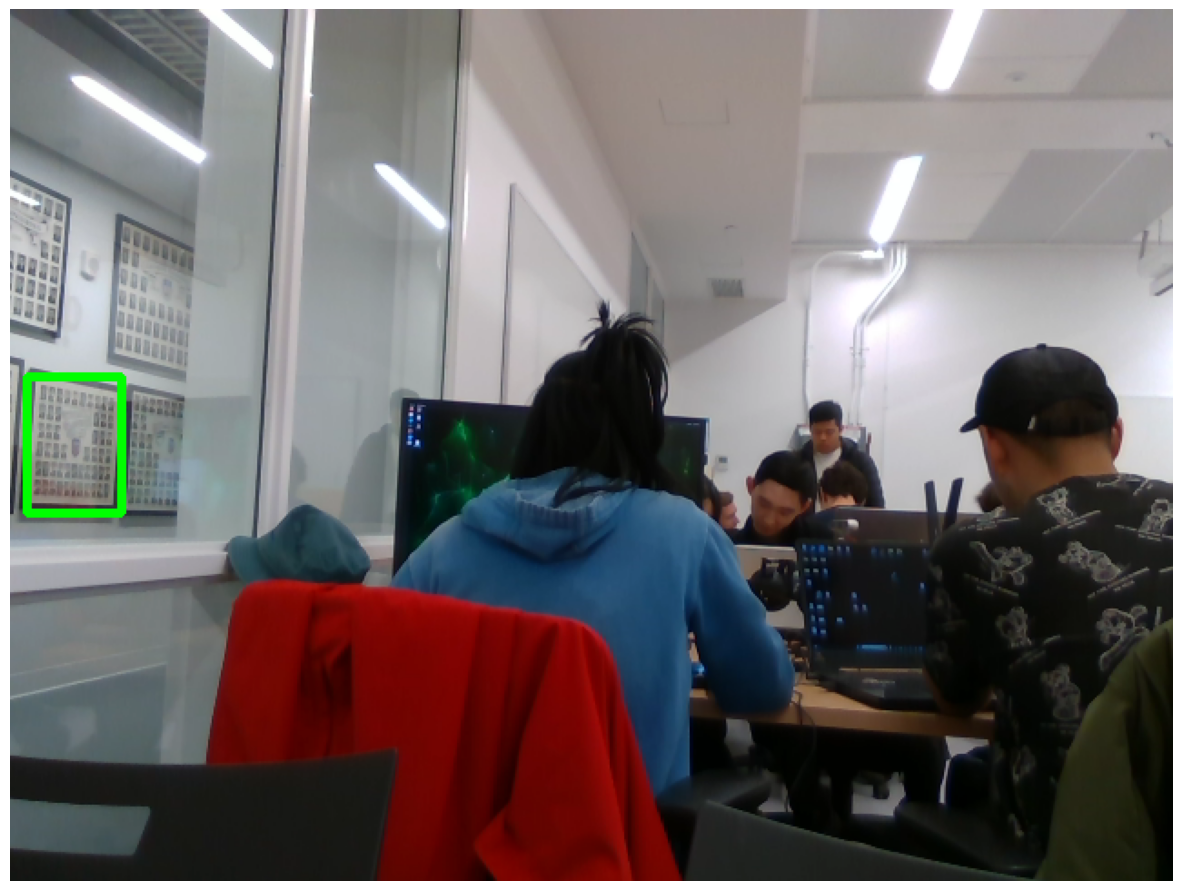

In [23]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv

img_dir = "./archive/Train/14/"
files = np.random.choice(os.listdir(img_dir), size = 20, replace = False)

def contrast_enhance(img):
    img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
    L, a, b = cv.split(img_lab)
    L = cv.equalizeHist(L)
    img_lab_merge = cv.merge((L, a, b))
    return cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)

def auto_canny(img, method = "triangle", sigma = 0.33):
    """
    Args:
    img: grayscale image
    method: Otsu, triangle, and median
    sigma: 0.33 (default)
    2 outputs:
    edge_detection output, the high threshold for Hough Transform"""
    if method=="median":
        Th = np.median(img)
        
    elif method=="triangle":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)
        
    elif method=="otsu":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_OTSU)
        
    else:
        raise Exception("method specified not available!")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh), highTh

# Color based segmentation
# Color based segmentation (red, blue, yellow, black)
# Red color
lower_red1 = (0, 40, 50)
upper_red1 = (10, 255, 210)
lower_red2 = (165, 40, 50)
upper_red2 = (179, 255, 210)

# Blue color 
lower_blue = (90, 40, 50)
upper_blue = (120, 255, 210)

# Yellow colors
lower_yellow = (20, 40, 50)
upper_yellow = (35, 255, 210)

# black colors
lower_black = (0, 0, 0)
upper_black = (179, 255, 5)

def color_seg(img, kernel_size=None):
    """Args:
    img: image in bgr
    kernel_size: None (default:(3, 3))"""
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    mask_red1 = cv.inRange(hsv_img, lower_red1, upper_red1)
    mask_red2 = cv.inRange(hsv_img, lower_red2, upper_red2)
    mask_blue = cv.inRange(hsv_img, lower_blue, upper_blue)
    mask_yellow = cv.inRange(hsv_img, lower_yellow, upper_yellow)
    mask_black = cv.inRange(hsv_img, lower_black, upper_black)
    
    mask_combined = mask_red1 | mask_red2 | mask_blue | mask_yellow | mask_black
    
    if kernel_size is not None:
        kernel = np.ones(kernel_size, np.uint8)
    else:
        kernel = np.ones((3, 3), np.uint8)
        
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_OPEN, kernel)
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_CLOSE, kernel)
    
    return mask_combined

# rectangle detection (using Douglas-Peuker algorithm)
def cnt_rect(cnts, coef=0.1):
    contour_list = []
    for cnt in cnts:
        peri = cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, coef*peri, True)
        if len(approx) == 4:
            contour_list.append(cnt)

    if not contour_list:
        return None
    else:
        LC = max(contour_list, key=cv.contourArea)
        return LC
    
# circle detection
hough_circle_parameters = {
    "dp": 1,
    "minDist": 150,
    "param1": 200,    # adaptively change according to image
    "param2": 15,  
    "minRadius": 10,
    "maxRadius": 100
}
def cnt_circle(img, hough_dict = hough_circle_parameters):
    """Args:
    img: Grayscale Image after resizing
    cnt: contour
    hough_dict: hough_circle_transform parameters"""
    mask = np.zeros_like(img)
    circles = cv.HoughCircles(img, 
                              cv.HOUGH_GRADIENT, 
                              hough_dict["dp"], 
                              hough_dict["minDist"], 
                              param1=hough_dict["param1"], 
                              param2=hough_dict["param2"],
                              minRadius=hough_dict["minRadius"], 
                              maxRadius=hough_dict["maxRadius"])
    if circles is None:
        return circles
    else:
        # perform LCA
        list_circles = circles[0]
        largest_circles = max(list_circles, key=lambda x: x[2])
        center_x, center_y, r = largest_circles
        cv.circle(mask, (int(center_x), int(center_y)), int(r), 255)
        cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cnt = cnts[0]
        if len(cnts[0])>0:
            return max(cnt, key=cv.contourArea)
        else:
            return cnt[-1]
        
# combine the results of 2 shape detectors
def integrate_circle_rect(rect_cnt, circle_cnt, cnt):
    if circle_cnt is not None and rect_cnt is not None:
        # compare the area
        if cv.contourArea(circle_cnt) >= cv.contourArea(rect_cnt):
            output = circle_cnt
        else:
            output = rect_cnt

    elif circle_cnt is not None and rect_cnt is None:
        output = circle_cnt

    elif circle_cnt is None and rect_cnt is not None:
        output = rect_cnt

    else:
        if len(cnt)==0:
            return np.array([])
        else:
            output = max(cnt, key=cv.contourArea)

    return output

# combine the results of edge detector + color based segmentation followed by shape detection combined results
def integrate_edge_color(output1, output2):
    if not isinstance(output1, np.ndarray):
        output1 = np.array(output1)
        
    if not isinstance(output2, np.ndarray):
        output2 = np.array(output2)
        
    if len(output1)==0 and len(output2)==0:
        return np.array([])
    
    elif len(output1)==0 and output2.shape[-1]==2:
        return output2
    
    elif len(output2)==0 and output1.shape[-1]==2:
        return output1
    
    else:
        if cv.contourArea(output1[0]) > cv.contourArea(output2[0]):
            return output1
        else:
            return output2
        
def main():
    plt.figure(figsize=(15, 12))
    for i, img_file in enumerate(files):
        # Load the original image
        img_original = cv.imread(os.path.join(img_dir, img_file))
        if img_original is None:
            print(f"Error reading image: {img_file}")
            continue

        # Step 1: Contrast enhancement
        img_processed = contrast_enhance(img_original.copy())

        # Step 2: Convert to grayscale and detect edges
        img_gray = cv.cvtColor(img_processed, cv.COLOR_BGR2GRAY)
        img_canny, _ = auto_canny(img_gray, method="median")

        # Step 3: Perform color-based segmentation
        img_color = color_seg(img_processed)

        # Step 4: Find contours from edge and color-based segmentation
        canny_contours, _ = cv.findContours(img_canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        color_contours, _ = cv.findContours(img_color, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        # Step 5: Detect the largest rectangle from contours
        rect_from_canny = cnt_rect(canny_contours)
        rect_from_color = cnt_rect(color_contours)

        # Step 6: Choose the most relevant shape (rectangle)
        final_shape = rect_from_canny if rect_from_canny is not None else rect_from_color

        # Step 7: Draw a bounding box if a rectangle is detected
        if final_shape is not None:
            x, y, w, h = cv.boundingRect(final_shape)
            cv.rectangle(img_original, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Draw green bounding box

        # Display the original image with detected sign highlighted
        plt.subplot(5, 4, i + 1)
        plt.imshow(cv.cvtColor(img_original, cv.COLOR_BGR2RGB))
        plt.axis("off")

    plt.show()

# main()

plt.figure(figsize=(15, 12))
img_original = cv.imread("../rgb_image.png")

# Step 1: Contrast enhancement
img_processed = contrast_enhance(img_original.copy())

# Step 2: Convert to grayscale and detect edges
img_gray = cv.cvtColor(img_processed, cv.COLOR_BGR2GRAY)
img_canny, _ = auto_canny(img_gray, method="median")

# Step 3: Perform color-based segmentation
img_color = color_seg(img_processed)

# Step 4: Find contours from edge and color-based segmentation
canny_contours, _ = cv.findContours(img_canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
color_contours, _ = cv.findContours(img_color, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Step 5: Detect the largest rectangle from contours
rect_from_canny = cnt_rect(canny_contours)
rect_from_color = cnt_rect(color_contours)

# Step 6: Choose the most relevant shape (rectangle)
final_shape = rect_from_canny if rect_from_canny is not None else rect_from_color

# Step 7: Draw a bounding box if a rectangle is detected
if final_shape is not None:
    x, y, w, h = cv.boundingRect(final_shape)
    cv.rectangle(img_original, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Draw green bounding box

# Display the original image with detected sign highlighted
plt.subplot(1, 1, 1)
plt.imshow(cv.cvtColor(img_original, cv.COLOR_BGR2RGB))
plt.axis("off")

plt.show()